In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *

In [3]:
from fastai.vision.widgets import *
from fastai.vision.all import *

# Lesson 4 (suite): Gradient Descent with MNIST

In [7]:
from torchvision.datasets import MNIST

In [126]:
trainset = MNIST('../', download=True, train=True)
testset = MNIST('../', download=True, train=False)

In [11]:
trainset.data[0]  # looks like a five

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170, 253, 253, 253, 253, 253, 2

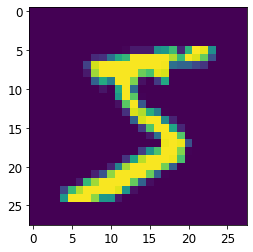

In [13]:
plt.imshow(trainset.data[0])

In [30]:
y_train = trainset.targets
y_test = testset.targets

y_train[0]  # indeed, the label for the first image is a 5

tensor(5)

In [15]:
# 60 000 images for training, 10 000 for testing
trainset.data.shape, testset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [127]:
# So we've got 60 000 square images of 28*28 pixels
# Those square images are nice for plotting and seing what's in there, 
# but we can't pass them to a linear model
# as seen in the lesson, use view or reshape to have all the pixels for an image in a single row 

train = trainset.data.reshape(60000, -1)
test = testset.data.reshape(10000, -1)

assert train.shape[1] == 784
assert test.shape[1] == 784

In [128]:
# FLoating point numbers work better with pytorch...
train.dtype

torch.uint8

In [129]:
# So we pass the data to float32 torch tensors
train = train.to(torch.float32)
test = test.to(torch.float32)

In [133]:
# The data isn't normalized
# use the tensor method we've seen in the 3.1 notebook to print the mean and 
# standard deviation of the data to see by yourself...
m, std = train.____(), train._____
print(m.item(), std.item())

assert m.item() == 33.31842041015625
assert std.item() == 78.56748962402344

33.31842041015625 78.56748962402344


In [34]:
# So we normalize it
train = (train - m) / std
test = __________________ # do the same for the test set
print(train.mean(), train.std())  # 0 and 1, good

tensor(1.8892e-08) tensor(1.)


We used the trainset mean and standard deviation to normalize the test set. This is perfectly normal and it is what you shoud always do ! 

## Define a fully connected neural net

In [51]:
def linear(x, neurons=50):
    # x is a n by m matrix;
    # to perform matrix operations, we want a 'm by neurons' matrix
    m = x.shape[1]
    w = torch.randn(m, neurons).requires_grad_()
    b = torch.randn(neurons).requires_grad_()
    return x @ w + b

In [52]:
def relu(x):
    return x.clamp_min(0.)

In [53]:
def model(x):
    x = linear(x, 50)
    x = relu(x)
    x = ______(x, 10)   # We want 10 outputs because we have 10 classes
    return x 

In [54]:
print("All possible classes (the numbers from 0 to 9):", y_train.unique())
print("That's", len(y_train.unique()), "classes")

All possible classes (the numbers from 0 to 9): tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
That's 10 classes


In [55]:
# input your train data into your model to get predictions...

output = _____(_____)
output.shape  # should be torch.Size([60000, 10]), 10 preds for each of the 60k imgs

torch.Size([60000, 10])

So our model outputs 10 numbers for each image in our dataset. You can think of those ten numbers as follow: 

"For this image, what is the probability that it is a 0 ? a one ? a two ? ... a nine ?" 

But are those numbers real probabilities ?

In [56]:
output[0]

tensor([ 425.5692,  199.6936,   40.0095,  278.0396,   -3.7494,  144.4044, -231.4400,   -7.4895,   17.7265,  129.2715], grad_fn=<SelectBackward>)

Absolutely not: most are greater than one, some are negative, and their sum doesn't add to 1. We'll use a loss function that is called <b>cross-entropy</b>. We'll review in more details how Cross-Entropy works in a future notebook, but for now you just need a broad understanding of what it does.

It does two thing:

- transform those numbers into numbers that behave like probabilities (they will sum to 1, and none will be greater than 1 or inferior to 0).
- out of these 10 probability, it picks the one that relates to the class your model should have predicted. If this number happens to be 1, great: you predicted 100% probability that is was the correct class. If it's less than that, you get a penalty.

## Forward pass

In [57]:
output = model(train)
loss = F.cross_entropy(output, y_train)
loss

tensor(211.9291, grad_fn=<NllLossBackward>)

## Training loop

In [119]:
#Data and labels:
INPUT = train
TARGETS = y_train

# parameters we can change:
EPOCHS = 25
LR = 0.5

In [120]:
# Create layers for our model
# help yourself with what we did in the above section
layer1 = torch._____([784, 50]).requires______()
activation = nn.ReLU()
layer2 = _____._____([__, __]).______________()

# Training loop
for i in range(EPOCHS):
    l1_output = activation(INPUT @ layer1)  # for code simplicity, we don't add the bias
    model_output = l1_output @ layer2

    loss = F.cross_entropy(____________, _______)
    if i%5 == 0:
        print(loss)
    loss.________()
    with torch.no_grad():
        layer1 -= layer1.grad * LR
        layer2 -= layer_.____ * __
        layer1.grad.zero_()
        layer2.____._____()

tensor(207.2033, grad_fn=<NllLossBackward>)
tensor(4.4755, grad_fn=<NllLossBackward>)
tensor(3.0572, grad_fn=<NllLossBackward>)
tensor(2.7618, grad_fn=<NllLossBackward>)
tensor(2.6250, grad_fn=<NllLossBackward>)


# Stochastic Gradient Descent

Stochastic Gradient Descent is just a fancy name for doing what we did above, except that instead of making predictions on ** all ** the pictures before we do gradient descent, we just take a bunch of them (say, 64), make predictions, and update our parameters

This is a good opportunity to work on your recall skills. Can you pull out the code out of your head without looking up ...? ;) 

In [121]:
# Create layers for our model
layer1 = ______________________________________
activation = ____________
layer2 = ______________________________________

# Training loop
for i in range(EPOCHS):
    for img_index in range(0, 60000, 64):  # we iterate through the images, 64 imgs at a time
        batch_of_sixtyfour_images = INPUT[img_index:img_index+64]

        l1_output = activation(batch_of_sixtyfour_images @ ______)  
        model_output = ___________________

        loss = ______________________________________________________________
        ______________
        with torch.no_grad():
            # update the parameters for layer1 and 2:


            # don't let the gradients accumulate:


    if i%5 == 0:
        print(loss)

tensor(1.9681, grad_fn=<NllLossBackward>)
tensor(1.0626, grad_fn=<NllLossBackward>)
tensor(0.3562, grad_fn=<NllLossBackward>)
tensor(0.3047, grad_fn=<NllLossBackward>)
tensor(0.2205, grad_fn=<NllLossBackward>)


As you can see, the models performs better. That's because it has had many more opportunities to learn. 